In [27]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

/home/schlotty/Documents/mn/metodos-num/tp3/notebooks
Python 3.6.9


# Auxiliares

In [89]:
vanilla = pd.read_csv('../data/train.csv')

def getData(src, fts):
    dst = src
    
    for f in fts:
        filtNull = dst[f].notnull()
        dst = dst[filtNull]
        
    return dst

In [150]:
#crea una matriz la cual tiene cada feature en sus columnas
from sklearn.preprocessing import PolynomialFeatures


def crearPhi(features, data , label):
    vals = []
    for f in features: 
        x = data[f].dropna().values
        #x /= np.linalg.norm(x)
        vals.append(x)
    
    
    y = data[label].dropna().values 
    
    sinNan = min(len(y) , min([len(s) for s in vals ]))
    y = y[:sinNan]
    y = y.reshape(len(y),1) 
    
    X = np.zeros((sinNan,len(features)))
    
    for i in range (len(features) ):
        X[:,i] = vals[i][:sinNan]
    
      
    return X, y
    

In [258]:
from sklearn.metrics import mean_squared_error,mean_absolute_error ,mean_squared_log_error

def train(df, fts, linear_regressor, poly = True,grado = 3):
    
    X, y_true = crearPhi(fts, df,"banos")
    
    if(poly):
        poly = PolynomialFeatures(grado)
        X = poly.fit_transform(X)

    linear_regressor.fit(X,y_true)

    return linear_regressor

def test(df, fts, linear_regressor,poly = True,grado = 3):
    
    X, y_true = crearPhi(fts, df,"banos")

    if(poly):
        poly = PolynomialFeatures(grado)
        X = poly.fit_transform(X)
    
    y_pred = linear_regressor.predict(X)
    
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    
    return rmse

def crossVal(df, fts, linear_regressor, k, poly=True, grado=3):
    rmse = []
    
    kf = KFold(n_splits=k, shuffle = False)
    
    for train_index, test_index in kf.split(df):
        predictorFiltrado = train(df.iloc[train_index], fts, linear_regressor, poly)
        rmse_i = test(df.iloc[test_index], fts, predictorFiltrado, poly)
        
        rmse.append(rmse_i)
        
    print(f"RMSE :{np.mean(np.array(rmse))}")
    

In [212]:
class dummyAproximator:
    def __init__(self, ctn):
        self.ctn = ctn
        return
    
    def fit(self, X, y):
        return
    
    def predict(self, X):
        return np.ones(X.shape[0])*(self.ctn)

In [227]:
def meanDummy(df, ft):
    cte = df[ft].mean()
    dummy = dummyAproximator(cte)
    
    return dummy

In [172]:
def plt2Dim(df, x, y, z) :
    plt.figure(figsize=(8,8))
    sns.scatterplot(data = df, x = x, y = y, hue = z )
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

# Globales

In [219]:
df = getData(vanilla, ["metroscubiertos", "banos", "antiguedad"])

# Nuestro aproximador
lr = metnum.LinearRegression()

In [259]:
def testAll(df, fts):
    print("dummy")
    crossVal(df, fts, meanDummy(df, "banos"), 5)
    print("lineal")
    crossVal(df, fts, lr, 5, poly=False)
    print("polinómica")
    crossVal(df, fts, lr, 5)

# Versión Cabeza

In [260]:
testAll(df, ['metroscubiertos','antiguedad'])

dummy
RMSE :0.8977755085290937
lineal
RMSE :0.8113935489623515
polinómica
RMSE :0.6158778695167589


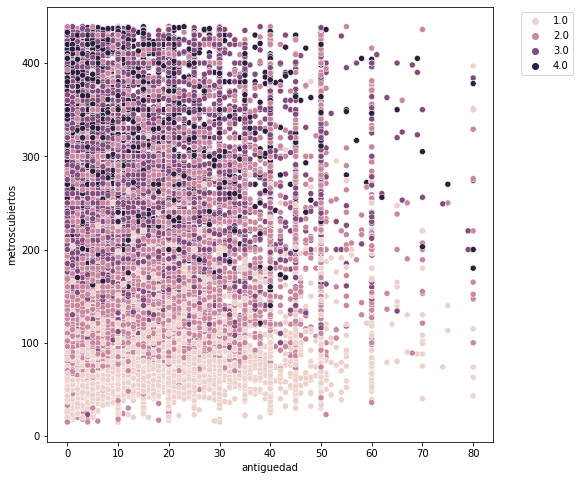

In [174]:
plt2Dim(df, "antiguedad", "metroscubiertos", "banos")

# Segmentación

In [261]:
def segment(df, fts, fltrs):

    i = 0
    
    for f in fltrs:
        i+=1
        print(f"==== {i}° Segmento ====")
        
        dt = df[f]
        print(f"Proporcion: {(len(dt)/len(df))*100}%")
        
        testAll(dt, fts)
        plt2Dim(dt, "antiguedad", "metroscubiertos", "banos")
    
    return 

## \# Habitaciones

==== 1° Segmento ====
Proporcion: 29.59403053347819%
dummy
RMSE :0.5657678092532474
lineal
RMSE :0.6304451935920189
polinómica
RMSE :0.44630650081700834


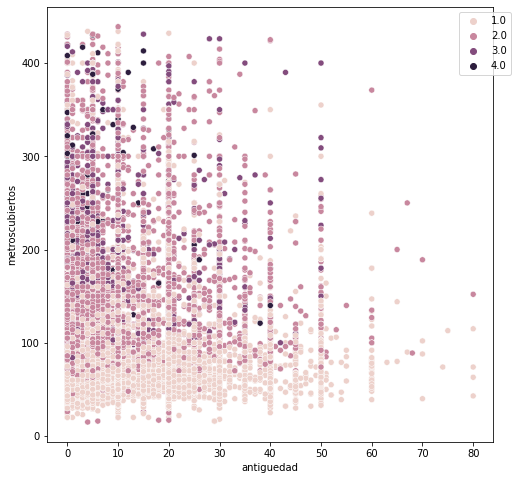

==== 2° Segmento ====
Proporcion: 55.54748699182343%
dummy
RMSE :0.8119073865367478
lineal
RMSE :0.8305107118256222
polinómica
RMSE :0.6185186727957326


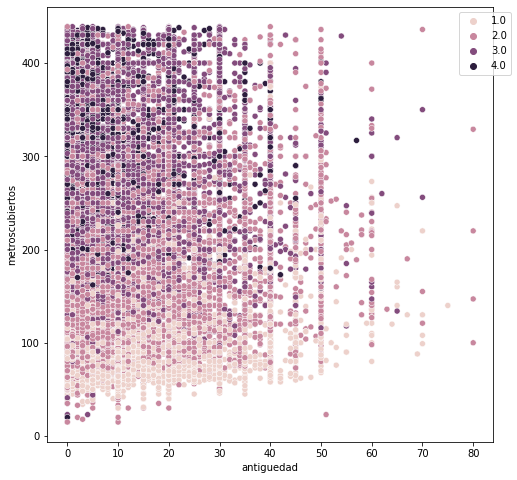

==== 3° Segmento ====
Proporcion: 13.107095888844416%
dummy
RMSE :0.8723981243223522
lineal
RMSE :0.9613997309094857
polinómica
RMSE :0.7577126134757115


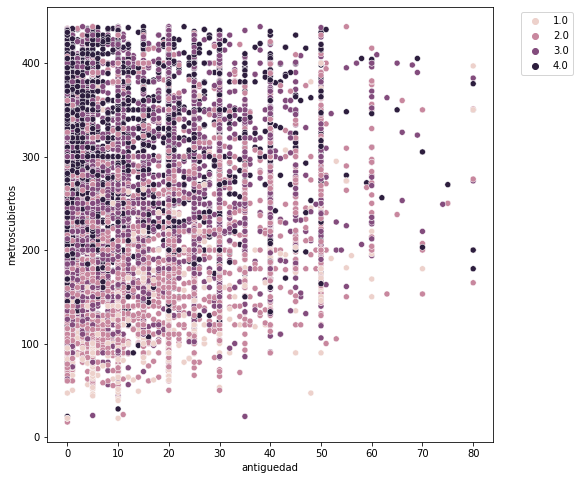

In [262]:
segments = [df["habitaciones"]<3, df["habitaciones"]==3, df["habitaciones"]>3]

segment(df, ["metroscubiertos", "antiguedad"], segments)

## 3 Habitaciones: Agregamos feature "precio"

dummy
RMSE :0.7697615972668945
lineal
RMSE :0.6993259305323694
polinómica
RMSE :0.6028465738070745
dummy
RMSE :0.7697615972668945
lineal
RMSE :0.6993367683658668
polinómica
RMSE :0.6146011784114281


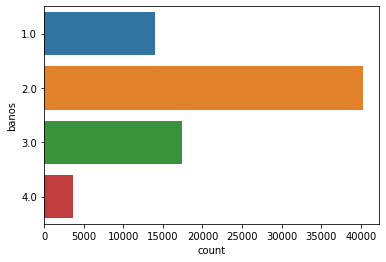

In [323]:
dt = getData(df, ["precio", "garages"])
dt = dt[(dt["habitaciones"] == 3) & (dt["precio"] < dt["precio"].quantile(.9))]
testAll(dt, ["metroscubiertos", "antiguedad", "garages"])
testAll(dt, ["metroscubiertos", "garages"])

sns.countplot(data=dt, y="banos")

dummy
RMSE :0.6674895504053584
lineal
RMSE :0.7670753618361608
polinómica
RMSE :0.5978470969251852
dummy
RMSE :0.6674895504053584
lineal
RMSE :0.7715128416417979
polinómica
RMSE :0.6211495890211103


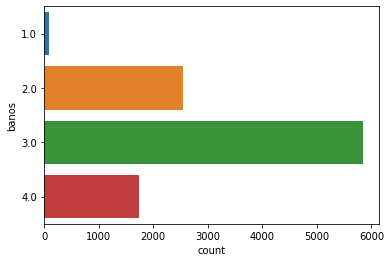

In [322]:
dt = getData(df, ["precio", "garages"])
dt = dt[(dt["habitaciones"] == 3) & (dt["precio"] >= dt["precio"].quantile(.9))]
testAll(dt, ["metroscubiertos", "antiguedad", "garages"])
testAll(dt, ["metroscubiertos", "garages"])

sns.countplot(data=dt, y="banos")

# Introducir Feature Engineering

# Quitar 4's

# Agrupar Valores